## Hardware measure postprocess

This example is designed to show how dask could be used with scientific instrumentation.  

The sample use case includes:
 - An actuator such as a motor that affects the outcome of the experiment.
 - A measurement instrument such as a camera
 - post processing that performs computation on the measurement data

Dask has generalized resource provisioning for workers.   

Dask often uses things like GPUs and memory to define resources for computation.   

Since resources are general we can define resources to specific workers and then constrain tasks to those specific workers.  

Post processing of the data can then occur as normally with dask.  

In this use case there is an implied state that the actuators are acting on the measurement.    

To enforce this constraint a dummy state variable is used as input and output for the hardware actions.  


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from skimage.feature import blob_doh
import asyncio as aio
import time

In [2]:
from dask.distributed import Scheduler, Worker, Nanny
from dask.distributed import SpecCluster
from dask.distributed import LocalCluster
from dask import delayed
from dask.distributed import Client
from dask import core
from dask.distributed import progress, wait
import dask

In [ ]:

scheduler = {'cls': Scheduler, 'options': {"dashboard_address": ':8787'}}
workers = {
    'my-camera': {"cls": Worker, "options": {"nthreads": 1}, "resources": {'camera': 1}},
    'my-motor': {"cls": Worker, "options": {"nthreads": 1}},
    'my-worker': {"cls": Worker, "options": {"nthreads": 1}},
    'my-nanny': {"cls": Nanny, "options": {"nthreads": 2}},
}
cluster = SpecCluster(scheduler=scheduler, workers=workers)

In [4]:
cluster.workers

{'my-worker': <Worker: 'tcp://192.168.1.21:44977', my-worker, Status.running, stored: 0, running: 0/1, ready: 0, comm: 0, waiting: 0>,
 'my-camera': <Worker: 'tcp://192.168.1.21:37455', my-camera, Status.running, stored: 0, running: 0/1, ready: 0, comm: 0, waiting: 0>,
 'my-motor': <Worker: 'tcp://192.168.1.21:45339', my-motor, Status.running, stored: 0, running: 0/1, ready: 0, comm: 0, waiting: 0>,
 'my-nanny': <Nanny: tcp://192.168.1.21:34471, threads: 2>}

In [5]:
c = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-4dd906d1-c460-11ea-b1ce-606c66c468aa
distributed.core - INFO - Starting established connection


In [9]:


def add_noise(pt, mu=0, sigma=1):
    np.random.seed(0)
    return pt + np.random.randn(*pt.shape) * sigma + mu


@delayed(pure=False)
def move_motor(s, pt):
    """
    simualating an actuator such, as a motor, which will effect an experiment
    """
    time.sleep(2)
    s = s + 1   
    return s


@delayed(pure=False)
def simulate_image(s, pt,sz=(1024, 1024)):
    """
    Simulating an instrument measurement
    """
    pt = add_noise(pt, sigma=0.1)
    img = np.zeros(sz)
    x = np.arange(1024) / 512 -1
    y = np.arange(1024) / 512 -1
    img = xr.DataArray(img, dims=['x', 'y'], coords=[x, y])   
    gx, gy =xr.broadcast(img.coords['x'] + pt[0], img.coords['y'] + pt[1])
    img.values = 100/(1+ 100*gx*gx+100*gy*gy)
    time.sleep(1)
    s = s + 1
    return img
    
    
@delayed
def detect_point(img):
    """
    simulating some kind of post processing activity on the measurement data
    """
    blobs = blob_doh(img, max_sigma=100, threshold=.01)
    x, y, _ = blobs[0]
    time.sleep(2)
    return np.array((x, y))


# would like to create some high level graph or function for a single experiment

# async def experiment(pt):
#     await move_motor(pt)
#     pt = await add_noise(pt)
#     img = await simulate_image(pt)
#     pt = await detect_point(img)
#     return pt

# @delayed
# def experiment(pt):
#     s= move_motor(pt)
#     pt = add_noise(pt)
#     s, img = simulate_image(s, pt)
#     pt2 = detect_point(img)
#     return pt


In [10]:
# generate an experiment set with 3 cases

pts = [np.array([i*0.1, i*0.1]) for i in range(3)]

pts2=[]
state=0
for pt in pts:
    state= move_motor(state, pt)
    img = simulate_image(state, pt)  # I want to also return the state
    pt2 = detect_point(img)
    pts2.append(pt2)


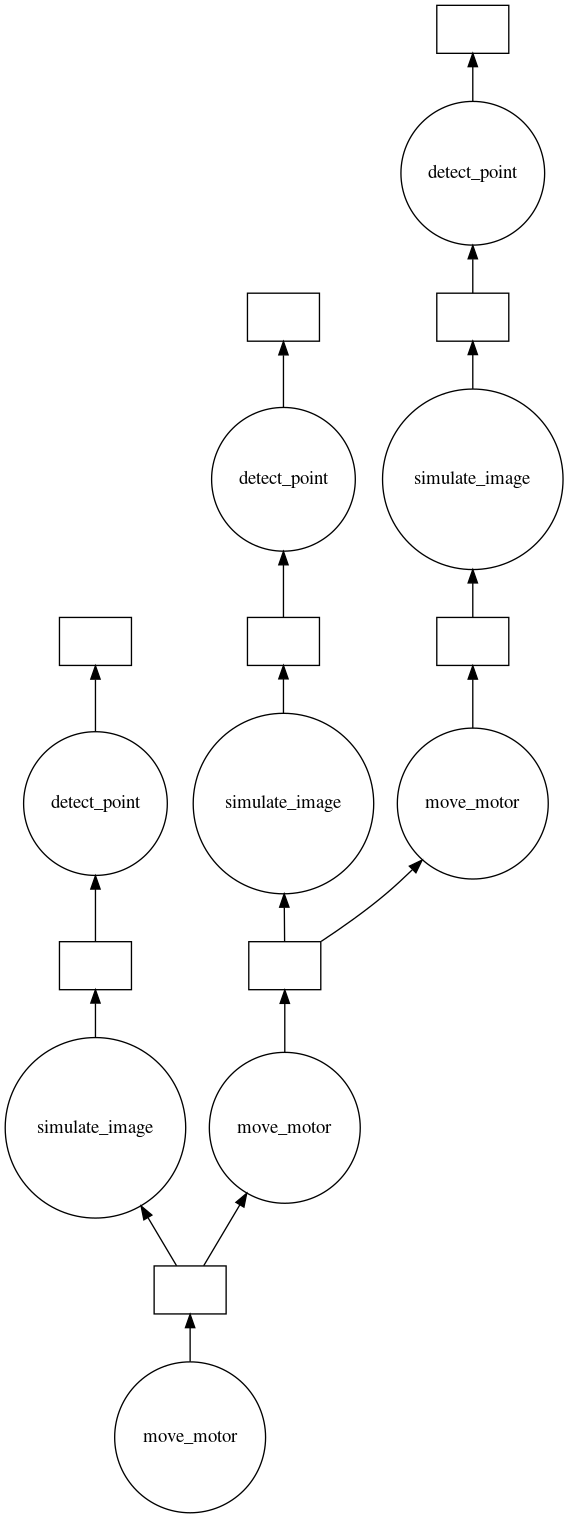

In [11]:
# visualize task graph 
# todo add constrain of move motor to wait for simulate image
dask.visualize(pts2)

In [12]:
result = dask.compute(pts2, workers={move_motor: 'my-motor',
                     simulate_image: 'my-camera'})

/opt/greg/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/opt/greg/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/opt/greg/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/opt/greg/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


In [13]:
result

([array([421., 491.]), array([369., 439.]), array([318., 388.])],)

In [10]:
# c.submit(pts2, (), workers={move_motor: 'my-motor',
#                      simulate_image: 'my-camera'})

In [14]:
s=0
pt1 = np.array([0,0])
pt=pt1
s= move_motor(s,pt)
img = simulate_image(s, pt)
pt2 = detect_point(img)
im_data = c.persist(img)

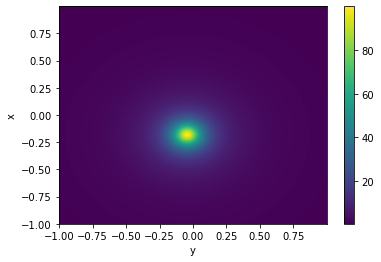

In [15]:
im_data.compute().plot()

In [20]:
c.shutdown()

distributed.worker - INFO - Stopping worker at tcp://192.168.1.21:42809
distributed.nanny - INFO - Closing Nanny at 'tcp://192.168.1.21:35813'
distributed.worker - INFO - Stopping worker at tcp://192.168.1.21:45805
distributed.worker - INFO - Stopping worker at tcp://192.168.1.21:38265
distributed.scheduler - INFO - Remove worker <Worker 'tcp://192.168.1.21:42809', name: my-camera, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://192.168.1.21:42809
distributed.scheduler - INFO - Remove worker <Worker 'tcp://192.168.1.21:44163', name: my-nanny, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://192.168.1.21:44163
distributed.scheduler - INFO - Remove worker <Worker 'tcp://192.168.1.21:45805', name: my-worker, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://192.168.1.21:45805
distributed.scheduler - INFO - Remove worker <Worker 'tcp://192.168.1.21:38265', name: my-motor, memory: 1, processing: 0>
distributed.